In [1]:
# Импорты нужных библиотек и функций
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from datetime import datetime
from matplotlib import gridspec
from math import ceil

### Загрузим данные из таблицы ab_test_cookies.csv:

In [2]:
ab_test_cookies = pd.read_csv('ab_test_cookies.csv')
ab_test_cookies.head()

,cookie_id,grp
0,65hj0vyf6kfrckx,A
1,dnjw8oy95td2jqf,B
2,beiyb0xfie92m43,B
3,xyd746tr80pnnbi,B
4,dpq6rqi93zgekgv,A


In [3]:
ab_test_cookies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253172 entries, 0 to 253171
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   cookie_id  253172 non-null  object
 1   grp        253172 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


### Загрузим данные о регистрациях пользователей из таблицы registrations_in_test_period.csv:

In [4]:
regs = pd.read_csv('registrations_in_test_period.csv')
regs.head()

,cookie_id,user_id
0,NaN,382603
1,NaN,295154
2,NaN,999732
3,NaN,16486
4,NaN,678352


In [5]:
regs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172350 entries, 0 to 172349
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   cookie_id  72485 non-null   object
 1   user_id    172350 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.6+ MB


### Загрузим данные  о покупках из таблицы purchases_in_test_period.csv:

In [6]:
purchases = pd.read_csv('purchases_in_test_period.csv')
purchases.head()

,purchase_id,user_id,amount
0,1,275851,350
1,2,923077,1500
2,3,959409,50
3,4,692022,350
4,5,737918,50


In [7]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35147 entries, 0 to 35146
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   purchase_id  35147 non-null  int64
 1   user_id      35147 non-null  int64
 2   amount       35147 non-null  int64
dtypes: int64(3)
memory usage: 823.9 KB


### Объеденим таблицу лендинга с таблицей о регистрациях пользователях

In [8]:
ab_test_user_groups = ab_test_cookies.merge(regs, on = 'cookie_id', how='left')
ab_test_user_groups.head()

,cookie_id,grp,user_id
0,65hj0vyf6kfrckx,A,716849.0
1,dnjw8oy95td2jqf,B,NaN
2,beiyb0xfie92m43,B,NaN
3,xyd746tr80pnnbi,B,NaN
4,dpq6rqi93zgekgv,A,NaN


### Так как у пользователя может быть несколько покупок, нам нужно провести агрегацию по пользователю в таблице о покупках:

In [9]:
purchases_group = purchases.groupby('user_id', as_index = False).agg({'amount':'sum'})
purchases_group.head()

,user_id,amount
0,0,350
1,27,700
2,33,350
3,61,50
4,76,1500


### Объеденим таблицу с платежами и объедененную таблицу с регистрациями

In [10]:
ab_data = ab_test_user_groups.merge(purchases_group, on='user_id', how='left')
ab_data.head()

,cookie_id,grp,user_id,amount
0,65hj0vyf6kfrckx,A,716849.0,NaN
1,dnjw8oy95td2jqf,B,NaN,NaN
2,beiyb0xfie92m43,B,NaN,NaN
3,xyd746tr80pnnbi,B,NaN,NaN
4,dpq6rqi93zgekgv,A,NaN,NaN


### Посмотрим в каких пропорциях разбиты пользователи на группы, сколько посетителей и пользователей  в каждой группе:

In [11]:
ab_summary = ab_data.groupby('grp').agg({'cookie_id':'count','user_id':'count'})
ab_summary.rename(columns={'cookie_id':'Количество посетителей','user_id':'Количество пользователей'},  inplace=True)
ab_summary

,Количество посетителей,Количество пользователей
grp,,
A,101329,31439
B,151843,41046


In [12]:
round(ab_summary.loc[ab_summary.index == 'A', 'Количество пользователей'].sum()/ab_summary['Количество пользователей'].sum(),2)

0.43

Мы видим что в нашем случае разбивка на группы составляет примерно 40/60

### Рассчитаем основные показатели (конверсию, средний чек, ARPU и т.д.)

In [13]:
# Конверсия
ab_summary['Конверсия'] = ab_summary['Количество посетителей']/ab_summary['Количество пользователей']
# Средний чек
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'amount':'mean'}).rename(columns = {'amount':'Средний чек'}), left_index=True, right_index=True)
# Выручка
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'amount':'sum'}).rename(columns={'amount':'Выручка'}), left_index=True, right_index=True)
# ARPU
ab_summary['ARPU'] = ab_summary['Выручка']/ab_summary['Количество пользователей']
# Дополнительная выручка (— выручка, которую пользователи принесли дополнительно, если считать базовой выручкой выручку всех 
# пользователей с ARPU, равным ARPU в контрольной группе.)
ab_summary['Доп. выручка'] = ab_summary['Количество пользователей']*(ab_summary['ARPU'] - ab_summary.loc['A', 'ARPU'])
ab_summary

,Количество посетителей,Количество пользователей,Конверсия,Средний чек,Выручка,ARPU,Доп. выручка
grp,,,,,,,
A,101329,31439,3.223035,553.052451,3216000.0,102.293330,0.000000e+00
B,151843,41046,3.699337,623.093100,5481350.0,133.541636,1.282618e+06


Мы рассчитали основные метрики А/В теста. Прооанализировав их можно сделать следющие выводы:
1. **Конверсия** во второй группе (В) выросла на 15% по сравнению с первой группой (А);
2. **Средний чек** во второй группе (В) вырос почти на 13 % по сравнению с первой группой (А);
3. **Выручка** во второй группе выросла (В) на 70 % по сравнению с первой группой (А);
4. **ARPU** вырос на 30 % и это отличный результат
5. **Дополнительная выручка** с пользователей второй группы (В) составила 1 282 618 руб.

In [14]:
ab = (ab_summary.loc['B','ARPU'] - ab_summary.loc['A','ARPU'])/ab_summary.loc['A','ARPU']*100
ab

30.547745674795625

### Проверка значимости изменений

#### Считаем значимость изменения конверсии.
Для этого можем использовать Z-test (т.к. конверсия это бинарная величина, пользователь либо купил, либо не купил)

In [15]:
print('P-value для конверсии составляет: ',
ztest(ab_data.loc[ab_data.grp == 'A', 'amount'].apply(lambda x: 1 if pd.notnull(x) else 0),
     ab_data.loc[ab_data.grp == 'B', 'amount'].apply(lambda x: 1 if pd.notnull(x) else 0) 
     ) [1] )

P-value для конверсии составляет:  0.5627358282855696


Мы видим что P-value очень мало, поэтому мы только можем сделать вывод что конверсия немного улучшилась.

#### Считаем изменения среднего чека и ARPU
Для этого мы можем использовать статистический тест Шапиро-Вилка для распределения средних чеков и покупок:

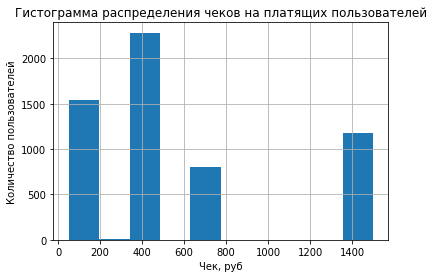

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk p-value is 0.0


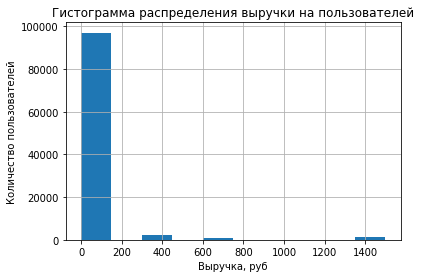

Shapiro-Wilk p-value is 0.0


In [16]:
ax = plt.subplot()
ab_data.loc[ab_data.grp == 'A', 'amount'].dropna().hist()
ax.set_xlabel('Чек, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения чеков на платящих пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'amount'].dropna())[1])

ax = plt.subplot()
ab_data.loc[ab_data.grp == 'A', 'amount'].fillna(0).hist()
ax.set_xlabel('Выручка, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения выручки на пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'amount'].fillna(0))[1])

По результатам теста Шапиро-Вилка, а также при визуальном анализе посторенных графиков мы видим что наше распределение **не является нормальным**. Поэтому используем t-test, и u-test (Манна-Уитни).

Для начала сравним средние чеки:

In [17]:
print(stats.mannwhitneyu(ab_data.loc[ab_data.grp == 'A', 'amount'].dropna(), ab_data.loc[ab_data.grp == 'B', 'amount'].dropna()),
stats.ttest_ind(ab_data.loc[ab_data.grp == 'A', 'amount'].dropna(), ab_data.loc[ab_data.grp == 'B', 'amount'].dropna())
      , sep = '\n')

MannwhitneyuResult(statistic=23997449.0, pvalue=1.5894355470534353e-11)
Ttest_indResult(statistic=-7.698737457881192, pvalue=1.4620086805787972e-14)


Как мы видим, средние чеки значимо различаются (так как p-value << 0.05) по каждому из тестов.

Затем сравним ARPU

In [18]:
print(stats.mannwhitneyu(ab_data.loc[ab_data.grp == 'A', 'amount'].fillna(0), ab_data.loc[ab_data.grp == 'B', 'amount'].fillna(0)),
      stats.ttest_ind(ab_data.loc[ab_data.grp == 'A', 'amount'].fillna(0), ab_data.loc[ab_data.grp == 'B', 'amount'].fillna(0)),
     sep = '\n')

MannwhitneyuResult(statistic=7687257761.0, pvalue=0.2131782418227564)
Ttest_indResult(statistic=-5.6615374023743055, pvalue=1.501844531390091e-08)


ARPU также статзначимо различаются (так как p-value << 0.05) по каждому из тестов.

### Строим доверительные интервалы

In [19]:
# Важные функции для получения доверительных интервалов
def get_conf_interval(data, conf_level = 0.95):  
# Считает доверительные интервалы для средних
        buf = (stats.t.interval(conf_level, len(data),
                             loc=np.mean(data), scale=stats.sem(data)))
        return (buf[1] - buf[0])/2
    
def get_conf_interval_z(succ, tot):  
# Считает доверительные интервалы для бинарных величин
    buf = proportion_confint(succ, tot)
    return buf[1] - buf[0]

In [20]:
get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'amount'].fillna(0)) 
# Доверительный полуинтервал для ARPU пользователей в группе А

1.0981455326877274

In [21]:
# Составляем словарь с доверительными интервалами для каждой метрики и для каждой группы
conf_intervals = {'ARPU':{'A':get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'amount'].fillna(0)),
                          'B':get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'amount'].fillna(0))},
                  'conversion':{'A':get_conf_interval_z(ab_data.loc[ab_data.grp == 'A', 'amount'].dropna().count(),
                                                        ab_data.loc[ab_data.grp == 'A', 'cookie_id'].count()),
                               'B':get_conf_interval_z(ab_data.loc[ab_data.grp == 'B', 'amount'].dropna().count(),
                                                        ab_data.loc[ab_data.grp == 'B', 'cookie_id'].count())},
                  'avg_bill':{'A':get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'amount'].dropna()),
                          'B':get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'amount'].dropna())}
                 }

In [22]:
conf_intervals

{'ARPU': {'A': 1.0981455326877274, 'B': 0.9918432756035216},
 'conversion': {'A': 0.002864084505223838, 'B': 0.0023501256269251175},
 'avg_bill': {'A': 13.259018604526204, 'B': 11.55088606505592}}

### Подготовка отчета

Подготовим отчет который будет включать все метрики, которые мы посчитали:

In [23]:
# Удобная функция для подстановки подписей на barplot
def set_labels(axes):  
# Расставляет подписи столбцов на барплоты
    y0, y1 = axes.get_ybound()  
# размер графика по оси Y
    y_shift = 0.15* (y1 - y0)  
# дополнительное место под надписи

    for i, rect in enumerate(axes.patches):  
# по всем нарисованным прямоугольникам
        height = rect.get_height()
        if abs(height) <= 10000:
            label = str(round(height, 2))
            if label[-1] == '0':
                label = label[:-1]
        elif abs(height) <= 1000000:
            label = str(round(height/1000, 1))
            if label[-1] == '0':
                label = label[:-1] + 'k'
            else:
                label = label + 'k'
        else:
            label = str(round(height/1000000, 2))
            if label[-1] == '0':
                label = label[:-1] + 'm'
            else:
                label = label + 'm'
        x = rect.get_x() + rect.get_width() / 2  
# посередине прямоугольника
        y = height + y_shift * 0.8  
# над прямоугольником в середине доп. места
        if height < 0:
            y = y_shift * 0.8 
        axes.text(x, y, label, ha='center', va='center', alpha = 0.7)
        axes.set_ybound(y0, y1 + 1.5*y_shift)

In [24]:
plot_summary = ab_summary.T 
# Транспонированная таблица для удобства использования
significant_changes = ['конверсия', 'Средний чек'] 
# Метрики со статзначимыми различиями

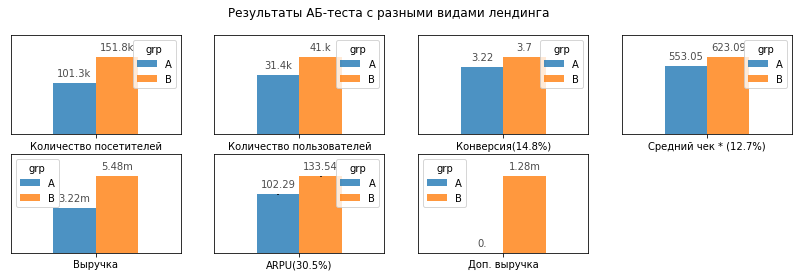

In [25]:
ax = [] 
# Массив для складирования графиков
n_pict_in_line = 4 
# Количество картинок в одной линии

gs = gridspec.GridSpec(ceil(len(plot_summary) / float(n_pict_in_line)), n_pict_in_line) 
# Создаём сетку для графиков
fig = plt.figure(figsize=(n_pict_in_line*3 + 2,
                          ceil(len(plot_summary) / n_pict_in_line) * 2))

## Считаем изменение метрики в процентах
delta_percent = {}
for row in plot_summary.index:  
    if 'Количество посетителей' != row and 'Количество пользователей' != row and 'Выручка' != row and "Доп. выручка" != row:
        delta_percent[row] = '(' + str(round(plot_summary.loc[row, :].max()/\
                                  plot_summary.loc[row, :].min()*100 - 100, 1)) + '%)'
        
fig.suptitle('Результаты АБ-теста с разными видами лендинга')

## Строим графики
for i, col in enumerate(plot_summary.index):
    ax.append(plt.subplot(gs[i // n_pict_in_line, i % n_pict_in_line])) 
# Добавляем subplot в нужную клетку
    plot_summary.loc[[col], :].plot(kind='bar', rot=0, ax=ax[i], alpha=0.8, 
# Строим график в нужной клетке
                                   yerr=conf_intervals[col] if col in conf_intervals else 0) 
    
    
# Редактируем подпись к графику, чтобы в ней хранилась информация о значимости различий 
    stars = ' * ' if col in significant_changes else '' 
    ticks = ax[-1].get_xticklabels()
    ticks[0] = col + stars + delta_percent[col] if col in delta_percent else col + stars
    ax[-1].set_xticklabels(ticks)
    ax[-1].set_yticks([])
    set_labels(axes=ax[i])

**На основании данного отчета можно сделать следующие выводы:**

- **ARPU** значимо вырос на 30,5 %.
- **Конверсия** значимо увеличилась на 14,8 %.
- **Средний чек** значимо увеличился на 12,7 %.
- Показ более длинного баннера, который объясняет все приемущества платформы (группа В) более выгоден чем показ короткого но яркого баннера, мотивирующего зарегистрироваться (группа А) 



**Рекомендации:**

На текущий рекомендуется можно оставить лендинг В для привлечения пользователей. В будущем возможно сделать комбинацию лендинга А и лендинга В, т.е. рассказывать о всех приемуществах платформы после привлечения пользователя или джаже после совершения им целевого действия. Возможно такая комбьинация будет более эффективна чем просто лендинг В